In [24]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

import os 
import sys 
import json

home = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
pths = [os.path.join(home, 'astrobot')]

for pth in pths: 
    if pth not in sys.path: sys.path.insert(0, pth)

from astrobot.util import *
from astrobot.geomdataframe import GeomDataFrame 
from astrobot.r import R
import astrobot.polymesh as polymesh
import astrobot.viz4 as viz
from astrobot import bem_util, geom_util, mtx_util


import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import itertools

# Results
from honeybee_energy.result.sql import SQLiteResult
from honeybee_energy.result import match 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
simdir_path = os.path.join('simulations', 'sim_0')

RDD_SRF_DICT = {
    'srf_out_temp': 'Surface Outside Face Temperature',
    'srf_in_temp': 'Surface Inside Face Temperature',
    'srf_heat_loss': 'Surface Window Heat Loss Energy',
    'srf_heat_gain': 'Surface Window Heat Gain Energy',
    'srf_win_sol': 'Surface Window Transmitted Solar Radiation Energy'
}

In [26]:
r = R(pd.read_pickle(os.path.join(simdir_path, 'rmod_gen.pkl')))
r.spc = pd.read_pickle(os.path.join(simdir_path, 'rspc_gen.pkl'))
r.srf = pd.read_pickle(os.path.join(simdir_path, 'rsrf_gen.pkl'))
r.win = pd.read_pickle(os.path.join(simdir_path, 'rwin_gen.pkl'))
r

mod: ['wwr', 'theta', 'mod_geom', 'mod']
spc: ['mod_idx', 'spc_geom']
srf: ['mod_idx', 'spc_idx', 'srf_geom', 'type', 'bc']
win: ['mod_idx', 'spc_idx', 'srf_idx', 'win_geom']

In [27]:
rdd_srf_var = RDD_SRF_DICT['srf_win_sol']
rdatas = []
print(rdd_srf_var)
for mod in r.mod['mod']:
    bldid = mod.identifier.replace('model', 'building')
    sql_fpath = os.path.join(simdir_path, bldid, 'run', 'eplusout.sql')

    # actual 
    sql = SQLiteResult(sql_fpath)
    rdata = sql.data_collections_by_output_name(rdd_srf_var)
    
    rdatas.extend(rdata)    

Surface Window Transmitted Solar Radiation Energy


In [28]:
#r.srf['srf_out_temp'] = [rd.total for f, rd in match.match_faces_to_data(rdatas, r.srf.srf_geom)]
matched = match.match_faces_to_data(rdatas, r.srf.srf_geom)

r.win['sol'] = [np.round(r.total / 72.0, 2) for f, r in matched]
r.win['theta'] = [geom_util.to_lb_theta(t) for t in r.mod['theta']]
r.win['wwr'] = r.mod['wwr']
r.win[r.win.columns]


,mod_idx,spc_idx,srf_idx,win_geom,sol,theta,wwr
idx,,,,,,,
0,0,0,3,Aperture: mod_0_spc_0..Face3_Glz1,4.78,0.0,0.20
1,1,1,9,Aperture: mod_1_spc_0..Face3_Glz1,10.66,270.0,0.20
2,2,2,15,Aperture: mod_2_spc_0..Face3_Glz1,13.95,180.0,0.20
3,3,3,21,Aperture: mod_3_spc_0..Face3_Glz1,13.12,0.0,0.55
4,4,4,27,Aperture: mod_4_spc_0..Face3_Glz1,29.29,270.0,0.55
5,5,5,33,Aperture: mod_5_spc_0..Face3_Glz1,38.35,180.0,0.55
6,6,6,39,Aperture: mod_6_spc_0..Face3_Glz1,21.40,0.0,0.90
7,7,7,45,Aperture: mod_7_spc_0..Face3_Glz1,47.88,270.0,0.90
8,8,8,51,Aperture: mod_8_spc_0..Face3_Glz1,62.73,180.0,0.90


In [29]:
# Viz
r.srf['type'] = [srf.type.name for srf in r.srf['srf_geom']]
r.srf['bc'] = [srf.boundary_condition.name for srf in r.srf['srf_geom']]
r.srf['mtx_geom'] = \
    [polymesh.PolyMesh(geom_util.verts_to_pntmtx(f.vertices)) for f in r.srf['srf_geom']]
r.win['mtx_geom'] = \
    [polymesh.PolyMesh(geom_util.verts_to_pntmtx(f.vertices)) for f in r.win['win_geom']]

In [30]:
print(r.srf.columns)
device = polymesh.DEFAULT_RENDER_DEVICE()
polymeshes_lst = []
rgb_mtx_lst = []
rgbd = polymesh.RGB_DICT

# groupby type
#for mod_idx in r.mod['idx']:
for t, srfs in r.srf.query('mod_idx == 1').groupby('type'):
    trimeshes = srfs.mtx_geom.to_list()
    rgb_mtx_lst.extend([trimesh.rgb_mtx(rgbd['blue']/255.0) for trimesh in trimeshes])
    polymeshes_lst.extend(trimeshes)
    
win = r.win.query('mod_idx == 1')
win_trimeshes = win.mtx_geom.to_list()

polymeshes_lst.extend(win_trimeshes)
rgb_mtx_lst.extend([wtmesh.rgb_mtx(rgbd['gold']/255.0) for wtmesh in win_trimeshes])

Index(['mod_idx', 'spc_idx', 'srf_geom', 'type', 'bc', 'mtx_geom'], dtype='object')


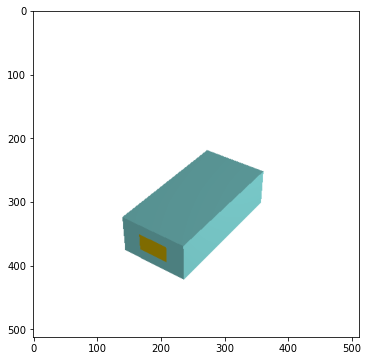

In [39]:
pytmeshes = polymesh.pytmeshes(polymeshes_lst, 
                               textures=polymesh.pytmeshes_textures(rgb_mtx_lst), 
                               device=device)
images = viz.simple_cam(pytmeshes, elev=35, dist=50, azim=-55, 
                        cam_pt=(0, 2, 0), light_pt=(10, 10, 35))
plt.figure(figsize=(6, 6))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid(False)